In [1]:
from google.colab import drive #đăng nhập drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pandas as pd

import tensorflow as tf

from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from keras.utils.np_utils import to_categorical
from keras.layers.convolutional import Conv2D, MaxPooling2D
from sklearn.model_selection import train_test_split

import os
import random
from keras.preprocessing.image import ImageDataGenerator

physical_devices = tf.config.list_physical_devices("GPU")
tf.config.experimental.set_memory_growth(tf.config.list_physical_devices("GPU")[0], True)

################ Parameters #####################
path = "/content/drive/MyDrive/final_data"  # folder chứa 15 folder của các classes
testRatio = 0.2  # Chia 20% số ảnh cho testing
validationRatio = 0.2  # Còn lại 80% cho train => Chia 20% cho validation

In [4]:
# Import Ảnh
count = 0
images = []
classNo = []
myList = os.listdir(path)
print("Tổng số Classes: ", len(myList))
noOfClasses = len(myList)
print("Importing Classes.....")
for x in range(0, len(myList)):
    myPicList = os.listdir(path + "/" + str(count))
    for y in myPicList:
        curImg = cv2.imread(path + "/" + str(count) + "/" + y)
        curImg = cv2.resize(curImg, (32,32))
        images.append(curImg)
        classNo.append(count)
    print(count, end=" ")
    count += 1
print(" ")
images = np.array(images)
classNo = np.array(classNo)

Tổng số Classes:  15
Importing Classes.....
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14  


In [5]:
# Split Data
X_train, X_test, y_train, y_test = train_test_split(images, classNo, test_size=testRatio)
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=validationRatio)

# X_train = ARRAY OF IMAGES TO TRAIN
# y_train = CORRESPONDING CLASS ID

In [6]:

# Kiểm tra số lượng ảnh có bằng với số LABLES cho mỗi dataset
print("Data Shapes")
print("Train", end="");
print(X_train.shape, y_train.shape)
print("Validation", end="");
print(X_validation.shape, y_validation.shape)
print("Test", end="");
print(X_test.shape, y_test.shape)
assert (X_train.shape[0] == y_train.shape[0]), " TRAINING SET: Số lượng ảnh khác số lượng lables!"
assert (X_validation.shape[0] == y_validation.shape[0]), " VALIDATION SET: Số lượng ảnh khác số lượng lables!"
assert (X_test.shape[0] == y_test.shape[0]), " TESTING SET: Số lượng ảnh khác số lượng lables!"
assert (X_train.shape[1:] == (32,32,3)), " Kích thước ảnh Training SAI! "
assert (X_validation.shape[1:] == (32,32,3)), " Kích thước ảnh Validation SAI! "
assert (X_test.shape[1:] == (32,32,3)), " Kích thước ảnh Test SAI!"

Data Shapes
Train(18506, 32, 32, 3) (18506,)
Validation(4627, 32, 32, 3) (4627,)
Test(5784, 32, 32, 3) (5784,)


In [8]:
# READ CSV FILE
data = pd.read_csv('/content/drive/MyDrive/lables.csv') # File chứa tên và ID các classes
print("data shape ", data.shape, type(data))

data shape  (15, 2) <class 'pandas.core.frame.DataFrame'>


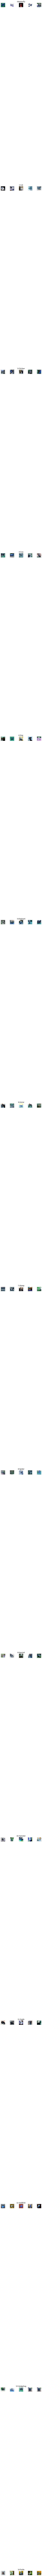

In [9]:
# Biểu diễn ngẫu nhiên một số ảnh mẫu
num_of_samples = []
cols = 5
num_classes = noOfClasses
fig, axs = plt.subplots(nrows=num_classes, ncols=cols, figsize=(5, 300))
fig.tight_layout()
for i in range(cols):
    for j, row in data.iterrows():
        x_selected = X_train[y_train == j]
        axs[j][i].imshow(x_selected[random.randint(0, len(x_selected) - 1), :, :], cmap=plt.get_cmap("gray"))
        axs[j][i].axis("off")
        if i == 2:
            axs[j][i].set_title(str(j) + "-" + row["Name"])
            num_of_samples.append(len(x_selected))

[1368, 1072, 2062, 1228, 3164, 947, 1656, 1140, 3092, 1194, 1319, 153, 39, 36, 36]


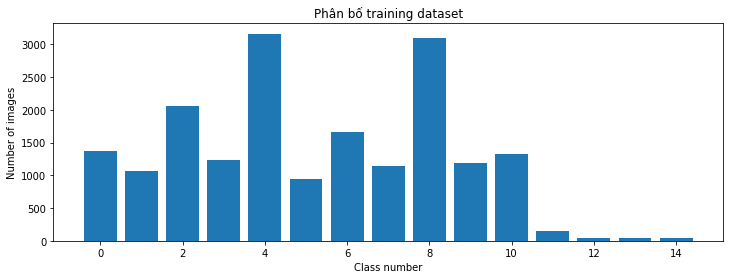

In [10]:
# PLOT biểu đồ cột về số lượng Samples cho mỗi loại
print(num_of_samples)
plt.figure(figsize=(12, 4))
plt.bar(range(0, num_classes), num_of_samples)
plt.title("Phân bố training dataset")
plt.xlabel("Class number")
plt.ylabel("Number of images")
plt.show()

In [11]:
# Xử lý ảnh
def preprocessing(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.equalizeHist(img)  # Cân bằng sáng cho ảnh
    img = img / 255  # Scale ảnh về giá trị 0-1
    return img

In [12]:
# Lấy ảnh đã xử lý và đưa vào lại các tập
X_train = np.array(list(map(preprocessing, X_train)))
X_validation = np.array(list(map(preprocessing, X_validation)))
X_test = np.array(list(map(preprocessing, X_test)))

In [13]:
# Reshape về (32,32,1)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
X_validation = X_validation.reshape(X_validation.shape[0], X_validation.shape[1], X_validation.shape[2], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)

In [14]:
# Rotate, shift-L/R, zoom images # nó sẽ quay hình qua lại cho mình để có thêm data
dataGen = ImageDataGenerator(width_shift_range=0.1,    # 0.1 = 10%     IF MORE THAN 1 E.G 10 THEN IT REFFERS TO NO. OF  PIXELS EG 10 PIXELS
                             height_shift_range=0.1,
                             zoom_range=0.2,  # 0.2 MEANS CAN GO FROM 0.8 TO 1.2
                             shear_range=0.1,  # MAGNITUDE OF SHEAR ANGLE
                             rotation_range=10)  # DEGREES
dataGen.fit(X_train)
batches = dataGen.flow(X_train, y_train,batch_size=20)  # REQUESTING DATA GENRATOR TO GENERATE IMAGES  BATCH SIZE = NO. OF IMAGES CREAED EACH TIME ITS CALLED
X_batch, y_batch = next(batches)

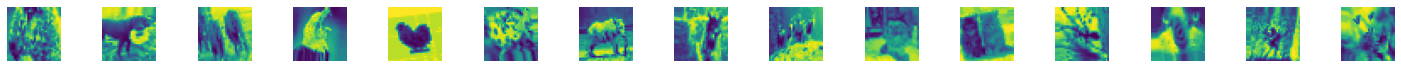

In [15]:
# Show ngẫu nhiên 15 ảnh sau xử lý
fig, axs = plt.subplots(1, 15, figsize=(20, 5))
fig.tight_layout()

for i in range(15):
    axs[i].imshow(X_batch[i].reshape((32, 32, 3)[0], (32, 32, 3)[1]))
    axs[i].axis('off')
plt.show()

In [16]:
# Chuyển thành one-hot # chuyển từ numberical sang array để có thể train được
y_train = to_categorical(y_train, noOfClasses)
y_validation = to_categorical(y_validation, noOfClasses)
y_test = to_categorical(y_test, noOfClasses)

In [17]:
# CNN Model dựa theo LeNet
def myModel():
    num_Filters = 60
    size_of_Filter = (5, 5)  # KERNEL size.
    size_of_Filter2 = (3, 3)
    size_of_pool = (2, 2)  # Pooling size
    model = Sequential()
    model.add((Conv2D(num_Filters, size_of_Filter, input_shape=((32, 32, 3)[0], (32, 32, 3)[1], 1), activation='relu')))
    model.add((Conv2D(num_Filters, size_of_Filter, activation='relu')))

    model.add((Conv2D(num_Filters // 2, size_of_Filter2, activation='relu')))
    model.add((Conv2D(num_Filters // 2, size_of_Filter2, activation='relu')))
    model.add(Dropout(0.5))  # => Giảm Overfitting

    model.add(Flatten())
    model.add(Dense(500, activation='relu'))  # HIDDEN LAYER
    model.add(Dropout(0.5))
    model.add(Dense(noOfClasses, activation='softmax'))  # OUTPUT LAYER
    # COMPILE MODEL
    model.compile(Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model



In [18]:
model = myModel()

In [21]:
#Train model
print(model.summary())

history = model.fit(dataGen.flow(X_train, y_train, batch_size=50),
                    epochs=100, validation_data=(X_validation, y_validation), shuffle=1)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 60)        1560      
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 60)        90060     
                                                                 
 conv2d_2 (Conv2D)           (None, 22, 22, 30)        16230     
                                                                 
 conv2d_3 (Conv2D)           (None, 20, 20, 30)        8130      
                                                                 
 dropout (Dropout)           (None, 20, 20, 30)        0         
                                                                 
 flatten (Flatten)           (None, 12000)             0         
                                                                 
 dense (Dense)               (None, 500)               6

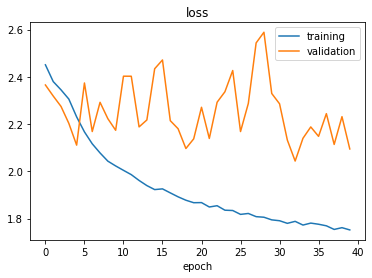

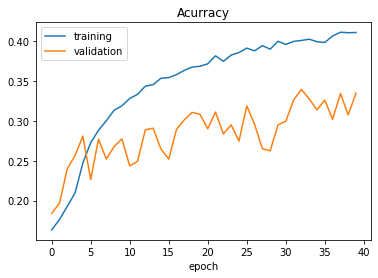

Test Score: 2.077709197998047
Test Accuracy: 0.3373744487762451


In [ ]:
# PLOT
plt.figure(1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('loss')
plt.xlabel('epoch')
plt.figure(2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training', 'validation'])
plt.title('Acurracy')
plt.xlabel('epoch')
plt.show()
score = model.evaluate(X_test, y_test, verbose=0)
print('Test Score:', score[0])
print('Test Accuracy:', score[1])

In [22]:
# Lưu model vào file .h5 để sử dụng cho real-time
model.save('/content/drive/MyDrive/data/model.h5')
cv2.waitKey(0)

-1

[[2.8985170e-09 2.0496640e-09 9.1999152e-07 ... 2.2158631e-14
  5.3376052e-14 3.7192155e-16]
 [4.1386121e-14 3.0105299e-13 3.4857256e-14 ... 2.6383438e-26
  6.5944497e-18 3.8654727e-16]
 [6.5036566e-04 4.9210043e-04 1.3635205e-02 ... 3.5245481e-08
  3.1381455e-04 2.5212218e-08]
 ...
 [6.8305001e-02 6.3094654e-04 1.4246954e-01 ... 1.1383343e-07
  3.5475045e-03 5.2599644e-04]
 [1.9267160e-01 5.9902545e-02 1.2416837e-02 ... 1.3336471e-06
  1.3794839e-05 2.0082238e-04]
 [2.3371215e-01 1.7558927e-04 1.3119812e-02 ... 9.6642680e-11
  2.0448912e-05 4.5327281e-05]]
[3 6 5 ... 8 8 8]
Confusion matrix, without normalization
[[319   1  18   6   9   1   4   2  72   5   0   0   0   0   0]
 [ 93  24  65   8  52   2   6  15  80   7   0   1   0   0   0]
 [ 97   1 340   8  29   2   6  21  78   6   0   1   0   0   0]
 [ 38   0  47 151  18   7  46  68  33   4   0   0   0   0   0]
 [130   8  98  41 322  12  62  64 210  19   1   3   0   0   0]
 [ 25   1  20  19  11  82  52  22  32   5   0   2   0   0   0]


<Figure size 432x288 with 0 Axes>

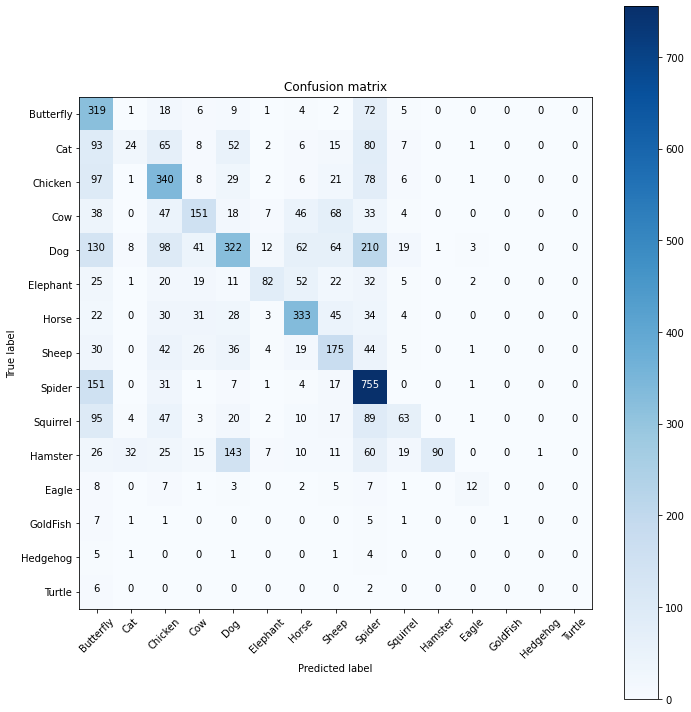

In [23]:
target_names = ['Butterfly',
            'Cat',
            'Chicken',
            'Cow',
            'Dog ',
            'Elephant',
            'Horse',
            'Sheep',
            'Spider',
            'Squirrel',
            'Hamster',
            'Eagle',
            'GoldFish',
            'Hedgehog',
            'Turtle',]


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')



from sklearn.metrics import classification_report,confusion_matrix
import itertools

Y_pred = model.predict(X_test)
print(Y_pred)
y_pred = np.argmax(Y_pred, axis=1)
print(y_pred)


cnf_matrix = (confusion_matrix(np.argmax(y_test,axis=1), y_pred))

np.set_printoptions(precision=2)

plt.figure()

# Plot non-normalized confusion matrix
plot_confusion_matrix(cnf_matrix, classes=target_names,
                      title='Confusion matrix')
#plt.figure()
# Plot normalized confusion matrix
#plot_confusion_matrix(cnf_matrix, classes=target_names, normalize=True,
#                      title='Normalized confusion matrix')
#plt.figure()
plt.show()

In [24]:
import numpy as np
import tensorflow as tf
import cv2
from keras.models import load_model

In [25]:
physical_devices = tf.config.list_physical_devices("GPU")
tf.config.experimental.set_memory_growth(tf.config.list_physical_devices("GPU")[0], True)
threshold = 0.75 #THRESHOLD của Xác Suất # là mức để máy xác định sự tự tin
font = cv2.FONT_HERSHEY_SIMPLEX

In [2]:
# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

In [4]:
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from google.colab.patches import cv2_imshow
from base64 import b64decode, b64encode
import numpy as np
import PIL
import io
import cv2
from keras.models import  load_model

# JavaScript to properly create our live video stream using our webcam as input
def preprocessing(img):# xử lý hình ảnh để đưa vô model dự đoán 
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.equalizeHist(img)
    img = img / 255
    return img
def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;
    
    var pendingResolve = null;
    var shutdown = false;
    
    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }
    
    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }
    
    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);
      
      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);
           
      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);
      
      const instruction = document.createElement('div');
      instruction.innerHTML = 
          '<span style="color: red; font-weight: bold;">' +
          'Bấm vào video để dừng</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };
      
      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 640; //video.videoWidth;
      captureCanvas.height = 480; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);
      
      return stream;
    }
    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();
      
      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }
            
      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }
      
      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;
      
      return {'create': preShow - preCreate, 
              'show': preCapture - preShow, 
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)
  
def video_frame(label, bbox):
  data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
  return data
# start streaming video from webcam
video_stream()
# label for video
label_html = 'Đang lấy hình ảnh...'
# initialze bounding box to empty
bbox = ''
count = 0 
#Load model nhận diện thú 
model_file_path ="/content/drive/MyDrive/data/model.h5"
model5 = load_model(model_file_path)
classes = ['Butterfly','Cat','Chicken','Cow','Dog','Elephant','Horse','Sheep','Spider','Squirrel','Hamster','Eagle','GoldFish','Hedgehog','Turtle']

while True:
    # Đọc ảnh trả về từ JS
    js_reply = video_frame(label_html, bbox)
    if not js_reply:
        break
    # Convert JS response to OpenCV image
    frame = js_to_image(js_reply["img"])

    # Resize để đưa vào model
    frame_p = cv2.resize(frame, dsize =(32, 32))
    frame_p = preprocessing(frame_p)
    tensor = np.expand_dims(frame_p, axis =0)
    # Feed vào mạng
    pred = model5.predict(tensor)
    class_id = np.argmax(pred)
    class_name = classes[class_id]
    #Vẽ lên 1 ảnh để tạo nửa overplay
    bbox_array = np.zeros([480,640,4], dtype=np.uint8)
   
    bbox_array = cv2.putText(bbox_array, "{}".format(class_name),
                        (10, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.5,
                        (0, 255,0), 2)

    bbox_array[:,:,3] = (bbox_array.max(axis = 2) > 0 ).astype(int) * 255
    # convert overlay of bbox into bytes
    bbox_bytes = bbox_to_bytes(bbox_array)
    # update bbox so next frame gets new overlay
    bbox = bbox_bytes

<IPython.core.display.Javascript object>

In [27]:
## CREATE VIRTUAL DISPLAY ###
!apt-get install -y xvfb # Install X Virtual Frame Buffer
import os
os.system('Xvfb :1 -screen 0 1600x1200x16  &')    # create virtual display with size 1600x1200 and 16 bit color. Color can be changed to 24 or 8
os.environ['DISPLAY']=':1.0'    # tell X clients to use our virtual DISPLAY :1.0.

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following NEW packages will be installed:
  xvfb
0 upgraded, 1 newly installed, 0 to remove and 49 not upgraded.
Need to get 784 kB of archives.
After this operation, 2,271 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic-updates/universe amd64 xvfb amd64 2:1.19.6-1ubuntu4.10 [784 kB]
Fetched 784 kB in 2s (469 kB/s)
Selecting previously unselected package xvfb.
(Reading database ... 155639 files and directories currently installed.)
Preparing to unpack .../xvfb_2%3a1.19.6-1ubuntu4.10_amd64.deb ...
Unpacking xvfb (2:1.19.6-1ubuntu4.10) ...
Setting up xvfb (2:1.19.6-1ubuntu4.10) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...


In [28]:
%matplotlib inline

In [29]:
### INSTALL GHOSTSCRIPT (Required to display NLTK trees) ###
!apt install ghostscript python3-tk

Reading package lists... Done
Building dependency tree       
Reading state information... Done
python3-tk is already the newest version (3.6.9-1~18.04).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  fonts-droid-fallback fonts-noto-mono gsfonts libcupsfilters1 libcupsimage2
  libgs9 libgs9-common libijs-0.35 libjbig2dec0 poppler-data
Suggested packages:
  fonts-noto ghostscript-x poppler-utils fonts-japanese-mincho
  | fonts-ipafont-mincho fonts-japanese-gothic | fonts-ipafont-gothic
  fonts-arphic-ukai fonts-arphic-uming fonts-nanum
The following NEW packages will be installed:
  fonts-droid-fallback fonts-noto-mono ghostscript gsfonts libcupsfilters1
  libcupsimage2 libgs9 libgs9-common libijs-0.35 libjbig2dec0 poppler-data
0 upgraded, 11 newly installed, 0 to remove and 49 not upgraded.
Need to get 14.1 MB of archives.
After this operation, 

In [5]:
pip install gradio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.1 MB 31.8 MB/s 
     |████████████████████████████████| 54 kB 3.5 MB/s 
     |████████████████████████████████| 256 kB 16.6 MB/s 
     |████████████████████████████████| 1.1 MB 57.1 MB/s 
     |████████████████████████████████| 84 kB 3.4 MB/s 
     |████████████████████████████████| 57 kB 5.3 MB/s 
     |████████████████████████████████| 140 kB 73.3 MB/s 
     |████████████████████████████████| 212 kB 73.5 MB/s 
     |████████████████████████████████| 2.3 MB 64.6 MB/s 
     |████████████████████████████████| 271 kB 77.5 MB/s 
     |████████████████████████████████| 94 kB 3.7 MB/s 
     |████████████████████████████████| 144 kB 76.6 MB/s 
     |████████████████████████████████| 63 kB 2.1 MB/s 
     |████████████████████████████████| 80 kB 9.8 MB/s 
     |████████████████████████████████| 43 kB 1.8 MB/s 
     |████████████████████████████████| 4.0 M

In [6]:
import gradio as gr
import tensorflow as tf
import numpy as np
import cv2

In [7]:
Labels = {  'Butterfly':0,
            'Cat':1,
            'Chicken':2,
            'Cow':3,
            'Dog ':4,
            'Elephant':5,
            'Horse':6,
            'Sheep':7,
            'Spider':8,
            'Squirrel':9,
            'Hamster':10,
            'Eagle':11,
            'GoldFish':12,
            'Hedgehog':	13,
            'Turtle':	14,}

In [8]:
from keras.models import  load_model
model5= load_model('/content/drive/MyDrive/data/model.h5')

In [9]:
def predict_image(img):

    img=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    img=cv2.resize(img,(32,32))
    img = np.array(img)/255.0
    img =img.reshape(1,32,32,1)
    
    predict =  np.argmax(model5.predict(img))
    
    if predict==0:
        return('Butterfly')
    elif predict==1: 
        return('Cat')
    elif predict==2: 
        return('Chicken')
    elif predict==3: 
        return('Cow')
    elif predict==4: 
        return('Dog')
    elif predict==5: 
        return('Elephant')
    elif predict==6: 
        return('Horse')
    elif predict==7: 
        return('Sheep')
    elif predict==8: 
        return('Spider')
    elif predict==9: 
        return('Squirrel')
    elif predict==10: 
        return('Hamster')
    elif predict==11: 
        return('Eagle')
    elif predict==12: 
        return('GoldFish')
    elif predict==13:
        return('Hedgehog')
    elif predict==14:
        return('Turtle')

In [ ]:
image = gr.inputs.Image()
label = gr.outputs.Label(num_top_classes=15)

gr.Interface(predict_image, inputs=image, outputs="text",interpretation='default').launch(debug='True')

/usr/local/lib/python3.7/dist-packages/gradio/deprecation.py:40: UserWarning: `optional` parameter is deprecated, and it has no effect
  warnings.warn(value)
/usr/local/lib/python3.7/dist-packages/gradio/deprecation.py:40: UserWarning: The 'type' parameter has been deprecated. Use the Number component instead.
  warnings.warn(value)


Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Running on public URL: https://15035.gradio.app

This share link expires in 72 hours. For free permanent hosting, check out Spaces (https://huggingface.co/spaces)


Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/gradio/routes.py", line 256, in run_predict
    fn_index, raw_input, username, session_state
  File "/usr/local/lib/python3.7/dist-packages/gradio/blocks.py", line 546, in process_api
    predictions, duration = await self.call_function(fn_index, processed_input)
  File "/usr/local/lib/python3.7/dist-packages/gradio/blocks.py", line 462, in call_function
    block_fn.fn, *processed_input, limiter=self.limiter
  File "/usr/local/lib/python3.7/dist-packages/anyio/to_thread.py", line 32, in run_sync
    func, *args, cancellable=cancellable, limiter=limiter
  File "/usr/local/lib/python3.7/dist-packages/anyio/_backends/_asyncio.py", line 937, in run_sync_in_worker_thread
    return await future
  File "/usr/local/lib/python3.7/dist-packages/anyio/_backends/_asyncio.py", line 867, in run
    result = context.run(func, *args)
  File "/usr/local/lib/python3.7/dist-packages/gradio/interface.py", line 650, in <lam